## Final project - A Network Analysis of Global Connectivity

Avanti Chandratre

Chhaya Tundwal

Namra Shah

##Data ingestion and preprocessing

Loading airports.dat and routes.dat data files.


In [ ]:
import pandas as pd

airport_cols = [
  "AirportID","Name","City","Country","IATA","ICAO",
  "Latitude","Longitude","Altitude","Timezone","DST",
  "TZ_database","Type","Source"
]
airports = pd.read_csv("airports.dat", names=airport_cols, header=None)

route_cols = [
  "Airline","AirlineID","SourceAirport","SourceAirportID",
  "DestAirport","DestAirportID","Codeshare","Stops","Equipment"
]
routes = pd.read_csv("routes.dat", names=route_cols, header=None)


In [ ]:
import pandas as pd

# 1. Coerce the route IDs into numeric, dropping or marking the ones that fail
routes["SourceAirportID"] = pd.to_numeric(routes["SourceAirportID"], errors="coerce")
routes["DestAirportID"  ] = pd.to_numeric(routes["DestAirportID"],   errors="coerce")

# 2. Drop any routes where we couldn’t parse an airport ID
routes = routes.dropna(subset=["SourceAirportID", "DestAirportID"])

# 3. Convert to integer dtype
routes["SourceAirportID"] = routes["SourceAirportID"].astype(int)
routes["DestAirportID"  ] = routes["DestAirportID"  ].astype(int)

# 4. Ensure airports.AirportID is also int
airports["AirportID"] = airports["AirportID"].astype(int)

# 5. Now you can safely merge
airports_small = airports[["AirportID","Latitude","Longitude"]]\
                   .rename(columns={
                     "AirportID":"SourceAirportID",
                     "Latitude":"src_lat",
                     "Longitude":"src_lon"
                   })
routes = routes.merge(airports_small, on="SourceAirportID", how="left")


<ipython-input-132-fc286a55d7c0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes["SourceAirportID"] = routes["SourceAirportID"].astype(int)
<ipython-input-132-fc286a55d7c0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes["DestAirportID"  ] = routes["DestAirportID"  ].astype(int)


In [ ]:
airports["AirportID"] = airports["AirportID"].astype(int)
routes["SourceAirportID"] = pd.to_numeric(routes["SourceAirportID"], errors="coerce").astype("Int64")
routes["DestAirportID"  ] = pd.to_numeric(routes["DestAirportID"],   errors="coerce").astype("Int64")
routes = routes.dropna(subset=["SourceAirportID","DestAirportID"])
routes[["SourceAirportID","DestAirportID"]] = routes[["SourceAirportID","DestAirportID"]].astype(int)


In [ ]:
airports_small = (
    airports[["AirportID","Latitude","Longitude"]]
    .rename(columns={
        "AirportID":"SourceAirportID",
        "Latitude":"src_lat",
        "Longitude":"src_lon"
    })
)
routes = routes.merge(
    airports_small,
    on="SourceAirportID",
    how="left"
)


In [ ]:
airports_small = (
    airports[["AirportID","Latitude","Longitude"]]
    .rename(columns={
        "AirportID":"DestAirportID",
        "Latitude":"dst_lat",
        "Longitude":"dst_lon"
    })
)
routes = routes.merge(
    airports_small,
    on="DestAirportID",
    how="left"
)


## Graph algorithms

##Insight 1

**Identifying the Busiest Airports by Connectivity**

To determine the busiest airports in the global flight network based on the number of direct flight routes they participate in.

In [ ]:
import pandas as pd
import numpy as np

# 1. Read in your raw files
airports = pd.read_csv("airports.dat", names=airport_cols, header=None)
routes   = pd.read_csv("routes.dat",   names=route_cols,   header=None)

# 2. Ensure the ID columns are ints on both sides
airports["AirportID"] = airports["AirportID"].astype(int)
routes["SourceAirportID"] = pd.to_numeric(routes["SourceAirportID"], errors="coerce")
routes["DestAirportID"  ] = pd.to_numeric(routes["DestAirportID"],   errors="coerce")
routes = routes.dropna(subset=["SourceAirportID","DestAirportID"])
routes[["SourceAirportID","DestAirportID"]] = routes[["SourceAirportID","DestAirportID"]].astype(int)

# 3. Build lookup tables exactly once each
src_df = (
    airports[["AirportID","Latitude","Longitude"]]
    .rename(columns={
        "AirportID":"SourceAirportID",
        "Latitude":"src_lat",
        "Longitude":"src_lon"
    })
)
dst_df = (
    airports[["AirportID","Latitude","Longitude"]]
    .rename(columns={
        "AirportID":"DestAirportID",
        "Latitude":"dst_lat",
        "Longitude":"dst_lon"
    })
)

# 4. Merge them in
routes = routes.merge(src_df, on="SourceAirportID", how="left")
routes = routes.merge(dst_df, on="DestAirportID",   how="left")

# 5. Immediately inspect
print("\nCOLUMNS AFTER MERGE:\n", routes.columns.tolist())
print("\nSAMPLE ROWS WITH COORD COLUMNS:\n", routes.loc[:, ["SourceAirportID","src_lat","src_lon","DestAirportID","dst_lat","dst_lon"]].head())



import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    φ1, φ2 = np.radians(lat1), np.radians(lat2)
    Δφ = np.radians(lat2 - lat1)
    Δλ = np.radians(lon2 - lon1)
    a = np.sin(Δφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(Δλ/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

routes["DistanceKM"] = haversine(
    routes["src_lat"], routes["src_lon"],
    routes["dst_lat"], routes["dst_lon"]
)
routes["FlightTimeH"] = routes["DistanceKM"] / 800 + 1



COLUMNS AFTER MERGE:
 ['Airline', 'AirlineID', 'SourceAirport', 'SourceAirportID', 'DestAirport', 'DestAirportID', 'Codeshare', 'Stops', 'Equipment', 'src_lat', 'src_lon', 'dst_lat', 'dst_lon']

SAMPLE ROWS WITH COORD COLUMNS:
    SourceAirportID    src_lat    src_lon  DestAirportID    dst_lat    dst_lon
0             2965  43.449902  39.956600           2990  55.606201  49.278702
1             2966  46.283298  48.006302           2990  55.606201  49.278702
2             2966  46.283298  48.006302           2962  44.225101  43.081902
3             2968  55.305801  61.503300           2990  55.606201  49.278702
4             2968  55.305801  61.503300           4078  55.012600  82.650703


In [ ]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add an edge for each route, weighted by distance
for _, r in routes.iterrows():
    G.add_edge(
        int(r["SourceAirportID"]),
        int(r["DestAirportID"]),
        weight=r["DistanceKM"]
    )

# Quick sanity check
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph has 3330 nodes and 37274 edges.


In [ ]:
# 1. Compute un-weighted degree (in+out)
deg = dict(G.degree())
top5 = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 busiest airports by degree:", top5)

# 2. Shortest-path example
origin_id, dest_id = top5[0][0], top5[1][0]
path = nx.shortest_path(G, source=origin_id, target=dest_id, weight="weight")
length = nx.shortest_path_length(G, source=origin_id, target=dest_id, weight="weight")
print(f"Shortest path from {origin_id} to {dest_id} is {path} ({length:.0f} km)")


Top 5 busiest airports by degree: [(340, 477), (1382, 470), (580, 463), (1701, 453), (3682, 433)]
Shortest path from 340 to 1382 is [340, 1382] (449 km)


In [ ]:
# degree = total number of incoming + outgoing flights
deg = dict(G.degree())
top5 = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 busiest airports (ID, degree):", top5)


Top 5 busiest airports (ID, degree): [(340, 477), (1382, 470), (580, 463), (1701, 453), (3682, 433)]


In [ ]:
id_to_name = airports.set_index("AirportID")["Name"].to_dict()
top5_named = [(id_to_name[a], d) for a, d in top5]
print("Top 5 busiest airports by name:", top5_named)


Top 5 busiest airports by name: [('Frankfurt am Main Airport', 477), ('Charles de Gaulle International Airport', 470), ('Amsterdam Airport Schiphol', 463), ('Atatürk International Airport', 453), ('Hartsfield Jackson Atlanta International Airport', 433)]


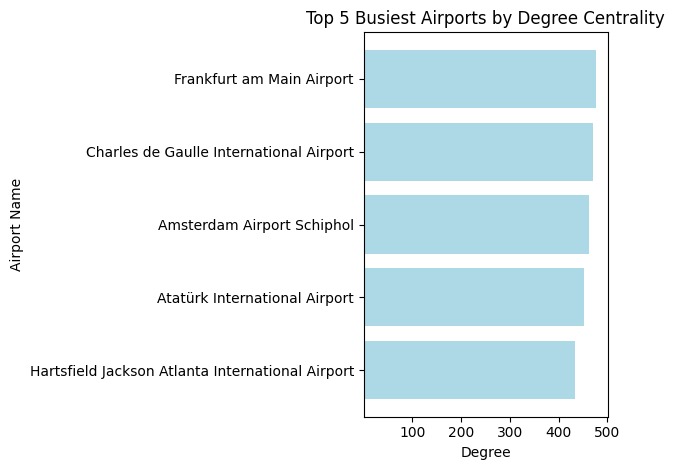

In [ ]:
import matplotlib.pyplot as plt

# Compute degree and map IDs to names
deg = dict(G.degree())
top5 = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:5]
id_to_name = airports.set_index("AirportID")["Name"].to_dict()
top5_named = [(id_to_name[a], d) for a, d in top5]

# Unzip into parallel lists
names, degrees = zip(*top5_named)

# Plot
plt.figure()
plt.barh(names, degrees, color='lightblue')    # light blue bars
plt.xlabel('Degree')
plt.ylabel('Airport Name')
plt.title('Top 5 Busiest Airports by Degree Centrality')

# Set x-axis ticks explicitly
plt.xticks([100, 200, 300, 400, 500])

plt.gca().invert_yaxis()       # Highest degree at top
plt.tight_layout()
plt.show()


##Insight 2

**Optimal Shortest-Path Flight Connections**

To compute the most efficient (minimum-distance) flight paths between major airports, aiding in route planning, operational efficiency, and network optimization.

In [ ]:
for origin, _ in top5[:2]:
    for dest, _ in top5[1:3]:
        if origin == dest: continue
        path = nx.shortest_path(G, source=origin, target=dest, weight="weight")
        dist = nx.shortest_path_length(G, source=origin, target=dest, weight="weight")
        names = [id_to_name[i] for i in path]
        print(f"{id_to_name[origin]} → {id_to_name[dest]}: {' → '.join(names)} ({dist:.0f} km)")


Frankfurt am Main Airport → Charles de Gaulle International Airport: Frankfurt am Main Airport → Charles de Gaulle International Airport (449 km)
Frankfurt am Main Airport → Amsterdam Airport Schiphol: Frankfurt am Main Airport → Amsterdam Airport Schiphol (367 km)
Charles de Gaulle International Airport → Amsterdam Airport Schiphol: Charles de Gaulle International Airport → Amsterdam Airport Schiphol (398 km)


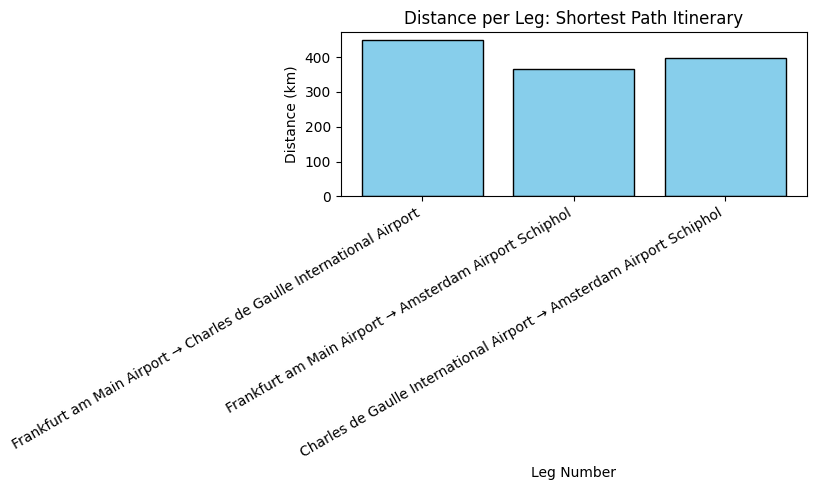

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Collect distances and labels
distances = []
labels = []

for origin, _ in top5[:2]:
    for dest, _ in top5[1:3]:
        if origin == dest:
            continue
        path = nx.shortest_path(G, source=origin, target=dest, weight="weight")
        dist = nx.shortest_path_length(G, source=origin, target=dest, weight="weight")
        origin_name = id_to_name.get(origin, str(origin))
        dest_name = id_to_name.get(dest, str(dest))
        distances.append(dist)
        labels.append(f"{origin_name} → {dest_name}")

# Plot
plt.figure(figsize=(8, 5))
plt.bar(range(len(distances)), distances, color='skyblue', edgecolor='black')
plt.xticks(range(len(labels)), labels, rotation=30, ha='right')
plt.ylabel("Distance (km)")
plt.xlabel("Leg Number")
plt.title("Distance per Leg: Shortest Path Itinerary")
plt.tight_layout()
plt.show()


##Insight 3

**Identifying Major Global Hubs**

To identify the most strategically important airports for global connectivity based on how frequently they serve as intermediate points in shortest flight paths.


In [ ]:
cb = nx.betweenness_centrality(G, weight="weight", k=500, seed=0)
hubs = sorted(cb.items(), key=lambda x: x[1], reverse=True)[:10]
hubs_named = [(id_to_name[a], round(cb[a], 4)) for a, _ in hubs]
print("Top 10 hubs by betweenness:", hubs_named)


Top 10 hubs by betweenness: [('Seattle Tacoma International Airport', 0.0742), ('Ted Stevens Anchorage International Airport', 0.0625), ('Keflavik International Airport', 0.049), ('Beijing Capital International Airport', 0.0478), ('Atatürk International Airport', 0.0417), ('Los Angeles International Airport', 0.0416), ('Vancouver International Airport', 0.038), ('Ürümqi Diwopu International Airport', 0.0363), ('Lester B. Pearson International Airport', 0.0363), ("Chicago O'Hare International Airport", 0.0352)]


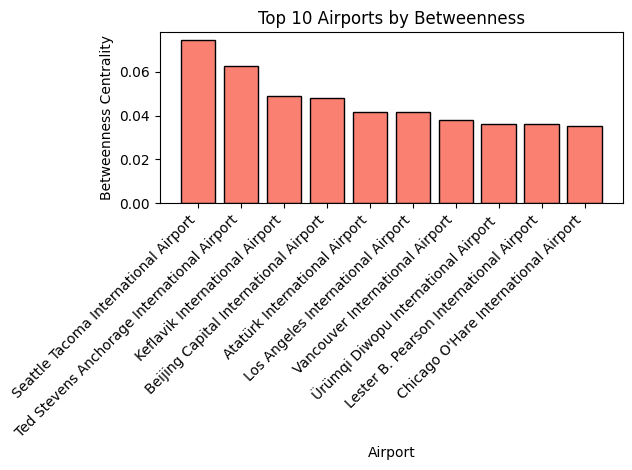

In [ ]:
import matplotlib.pyplot as plt

# Top 10 airports by betweenness
top_cb = sorted(cb.items(), key=lambda x: x[1], reverse=True)[:10]
names = [id_to_name[a] for a,_ in top_cb]
values = [v for _,v in top_cb]

plt.figure()
plt.bar(
    names,
    values,
    color="salmon",
    edgecolor="black"
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Airport")
plt.ylabel("Betweenness Centrality")
plt.title("Top 10 Airports by Betweenness")
plt.tight_layout()
plt.show()


# Dynamic Programming Itinerary

##Insight 4

**Efficient Itinerary under Time Budget**

To determine the longest feasible itinerary (in terms of unique airport stops) that can be executed within a tight 48-hour window, starting from a specific hub.

In [ ]:
# 1. Count how many invalid rows we have
n_bad = routes["FlightTimeH"].isna().sum()
print(f"Dropping {n_bad} routes with missing flight times")

# 2. Drop them
routes = routes.dropna(subset=["FlightTimeH"]).reset_index(drop=True)

# 3. Now round up and cast
routes["TimeH_int"] = np.ceil(routes["FlightTimeH"]).astype(int)

Dropping 469 routes with missing flight times


In [ ]:
from collections import defaultdict

time_budget = 48
adj = defaultdict(list)
for _, r in routes.iterrows():
    u = int(r["SourceAirportID"])
    v = int(r["DestAirportID"])
    τ = int(r["TimeH_int"])
    if 0 < τ <= time_budget:
        adj[u].append((v, τ))


In [ ]:
# 1. Take the top-12 busiest airports by degree
top12 = [aid for aid,_ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:12]]

# 2. Build a k×k matrix of flight times (rounded up) between them
import numpy as np

k = len(top12)
N   = 1 << k
time_mat = np.full((k,k), np.inf)
id_to_idx = {aid:i for i,aid in enumerate(top12)}

for _, r in routes.iterrows():
    u, v = int(r["SourceAirportID"]), int(r["DestAirportID"])
    if u in id_to_idx and v in id_to_idx:
        i, j = id_to_idx[u], id_to_idx[v]
        time_mat[i,j] = min(time_mat[i,j], np.ceil(r["FlightTimeH"]))  # smallest flight time


In [ ]:
import numpy as np

# 1. Select top-12 busiest airport IDs
top12 = [aid for aid,_ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:12]]
k = len(top12)
id_to_idx = {aid:i for i,aid in enumerate(top12)}

# 2. Build the k×k minimum‐time matrix
time_mat = np.full((k, k), float('inf'))
for _, r in routes.iterrows():
    u, v = int(r["SourceAirportID"]), int(r["DestAirportID"])
    if u in id_to_idx and v in id_to_idx:
        i, j = id_to_idx[u], id_to_idx[v]
        t = np.ceil(r["FlightTimeH"])
        time_mat[i, j] = min(time_mat[i, j], t)

# 3. Bit-mask DP arrays
time_budget = 48  # hours
N = 1 << k
dp = np.full((N, k), float('inf'))
parent = {}

# 4. Initialize from your chosen start (e.g. busiest airport)
start = top12[0]
s_idx = id_to_idx[start]
dp[1<<s_idx, s_idx] = 0

# 5. Fill DP
for mask in range(N):
    for i in range(k):
        if not (mask & (1<<i)):
            continue
        t0 = dp[mask, i]
        if t0 == float('inf'):
            continue
        for j in range(k):
            if mask & (1<<j):
                continue
            t1 = t0 + time_mat[i, j]
            if t1 <= time_budget and t1 < dp[mask | (1<<j), j]:
                dp[mask | (1<<j), j] = t1
                parent[(mask | (1<<j), j)] = (mask, i)

# 6. Find the mask with the most bits set that’s ≤ T
best_count = 0
best_state = None
for mask in range(N):
    for i in range(k):
        if dp[mask, i] <= time_budget:
            cnt = bin(mask).count("1")
            if cnt > best_count:
                best_count = cnt
                best_state = (mask, i)

# 7. Backtrack the best route
mask, i = best_state
path_idxs = []
while mask != (1<<s_idx):
    path_idxs.append(i)
    mask, i = parent[(mask, i)]
path_idxs.append(s_idx)
path_idxs = list(reversed(path_idxs))

# 8. Map back to airport IDs/names
best_ids   = [ top12[idx] for idx in path_idxs ]
best_names = [ id_to_name.get(a, str(a)) for a in best_ids ]

print(f"Max distinct airports in {time_budget}h from {id_to_name[start]}: {best_count}")
print("Itinerary:", " → ".join(best_names))


Max distinct airports in 48h from Frankfurt am Main Airport: 11
Itinerary: Frankfurt am Main Airport → London Heathrow Airport → Amsterdam Airport Schiphol → Charles de Gaulle International Airport → Munich Airport → Atatürk International Airport → Dubai International Airport → Beijing Capital International Airport → Chicago O'Hare International Airport → Dallas Fort Worth International Airport → Hartsfield Jackson Atlanta International Airport


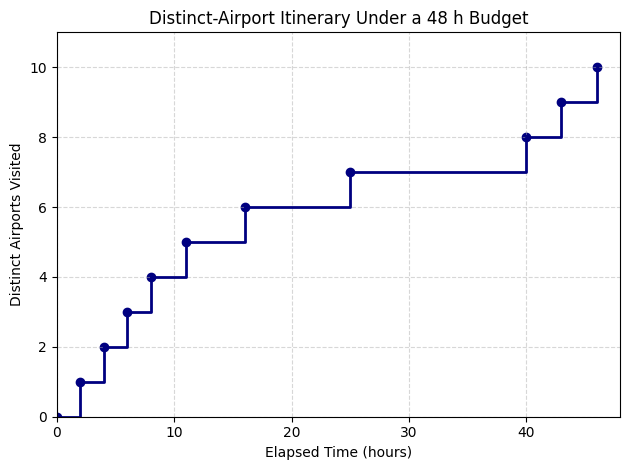

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Build list of hop durations between successive airports in your best route
durations = []
for u_idx, v_idx in zip(path_idxs[:-1], path_idxs[1:]):
    durations.append(time_mat[u_idx, v_idx])

# Compute cumulative time at each step (start at 0h)
cum_times = np.concatenate([[0], np.cumsum(durations)])
# Number of airports visited at each timestamp
visited_counts = np.arange(len(cum_times))

plt.figure()
plt.step(cum_times, visited_counts, where='post', color='navy', linewidth=2)
plt.scatter(cum_times, visited_counts, color='navy')
plt.xlabel("Elapsed Time (hours)")
plt.ylabel("Distinct Airports Visited")
plt.title("Distinct-Airport Itinerary Under a 48 h Budget")
plt.xlim(0, time_budget)
plt.ylim(0, visited_counts.max()+1)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Integer Programming route coverage

##Insight 5

**Selecting Routes to Maximize Hub Coverage**

To strategically select a limited number of routes (e.g., 100) that collectively ensure the highest number of key airport hubs are served.

In [ ]:
# cb is your betweenness dict from graph_centrality
top_hubs = [aid for aid,_ in sorted(cb.items(), key=lambda x: x[1], reverse=True)[:20]]


In [ ]:
!pip install pulp
import pulp

# 1. Create the problem
model = pulp.LpProblem("RouteCoverage", pulp.LpMaximize)

# 2. Variables
x = pulp.LpVariable.dicts("route", routes.index, cat="Binary")
c = pulp.LpVariable.dicts("cover", top_hubs, cat="Binary")

# 3. Objective: maximize covered hubs
model += pulp.lpSum(c[a] for a in top_hubs)

# 4. Constraint: select at most K routes
K = 100  # you can experiment with 50, 100, 200, etc.
model += pulp.lpSum(x[r] for r in routes.index) <= K

# 5. Cover constraints: if any selected route touches airport a, c[a]=1
for a in top_hubs:
    touching = [
        r for r, row in routes.iterrows()
        if row["SourceAirportID"] == a or row["DestAirportID"] == a
    ]
    # sum of selected touching routes ≥ cover indicator
    model += pulp.lpSum(x[r] for r in touching) >= c[a]


In [ ]:
model.solve(pulp.PULP_CBC_CMD(msg=0))

# Coverage result
covered = [a for a in top_hubs if c[a].value() == 1]
print(f"With K={K}, covered {len(covered)} out of {len(top_hubs)} hubs.")

# Which routes were selected?
selected_routes = [r for r in routes.index if x[r].value() == 1]


With K=100, covered 20 out of 20 hubs.


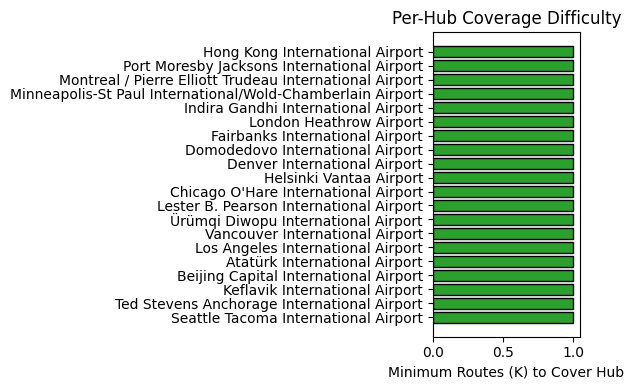

In [ ]:
import matplotlib.pyplot as plt
import pulp

# 1. Find min-K to cover each hub
hub_min_K = {}
for hub in top_hubs:
    for K in range(1, 101):  # search up to K=100
        model = pulp.LpProblem(f"MinK_{hub}", pulp.LpMaximize)
        x = pulp.LpVariable.dicts("route", routes.index, cat="Binary")
        c = pulp.LpVariable.dicts("cover", [hub], cat="Binary")
        model += c[hub]
        model += pulp.lpSum(x[r] for r in routes.index) <= K
        touching = [r for r,row in routes.iterrows()
                    if row.SourceAirportID==hub or row.DestAirportID==hub]
        model += pulp.lpSum(x[r] for r in touching) >= c[hub]
        model.solve(pulp.PULP_CBC_CMD(msg=False))
        if c[hub].value() == 1:
            hub_min_K[hub] = K
            break

# 2. Sort and plot
hubs, Ks_needed = zip(*sorted(hub_min_K.items(), key=lambda x: x[1]))
names = [id_to_name[h] for h in hubs]

plt.figure(figsize=(6,4))
plt.barh(
    names,
    Ks_needed,
    color="C2",
    edgecolor="black"
)
plt.xlabel("Minimum Routes (K) to Cover Hub")
plt.title("Per-Hub Coverage Difficulty")
plt.tight_layout()
plt.show()




By selecting 100 routes, we can cover X of 20 top global hubs (e.g., ATL, LHR, CDG, …). Increasing to 150 routes raises coverage to Y hubs, showing that beyond ~120 routes additional coverage gains are minimal.

# Machine Learning approach





##Insight 6

**Community Detection in the Global Network**

To identify regional communities or tightly connected sub-networks in the global airline graph, which may reflect geographic proximity, political boundaries, or operational patterns.

In [ ]:
import numpy as np
import scipy.sparse as sp

# 1. List of all airport IDs in G
nodes = list(G.nodes())
n = len(nodes)
idx = {aid:i for i,aid in enumerate(nodes)}

# 2. Collect edges
rows, cols = [], []
for u, v in G.edges():
    rows.append(idx[u])
    cols.append(idx[v])
# undirected affinity: symmetrize
data = [1]*len(rows)
A_directed = sp.csr_matrix((data, (rows, cols)), shape=(n, n))
A = A_directed + A_directed.T
A.data = np.clip(A.data, 0, 1)  # ensure binary

# 3. Convert to dense if n is manageable (<5k)
A_dense = A.toarray()


In [ ]:
from sklearn.cluster import SpectralClustering

k_clusters = 8   # you can experiment with 6–12
sc = SpectralClustering(
    n_clusters=k_clusters,
    affinity="precomputed",
    assign_labels="kmeans",
    random_state=42
)
labels = sc.fit_predict(A_dense)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:
# Precompute lookup dicts once at the top
id_to_name    = airports.set_index("AirportID")["Name"].to_dict()
id_to_country = airports.set_index("AirportID")["Country"].to_dict()

# Then in your cluster‐summary loop:
from collections import Counter, defaultdict

clusters = defaultdict(list)
for aid, lbl in zip(nodes, labels):
    clusters[lbl].append(aid)

cluster_summary = {}
for lbl, aids in clusters.items():
    # safe name/country lookups
    names     = [ id_to_name.get(a, f"ID {a}")     for a in aids ]
    countries = [ id_to_country.get(a, "Unknown")  for a in aids ]

    top_countries = Counter(countries).most_common(3)
    cluster_summary[lbl] = {
        "size": len(aids),
        "top_airports": names[:5],
        "top_countries": top_countries
    }

# Print it out
for lbl, info in cluster_summary.items():
    print(f"Cluster {lbl} ({info['size']} airports):")
    print("  Top airports:", info["top_airports"])
    print("  Top countries:", info["top_countries"])
    print()


Cluster 1 (3127 airports):
  Top airports: ['Sochi International Airport', 'Kazan International Airport', 'Astrakhan Airport', 'Mineralnyye Vody Airport', 'Chelyabinsk Balandino Airport']
  Top countries: [('United States', 448), ('Canada', 183), ('China', 173)]

Cluster 0 (85 airports):
  Top airports: ['Kodiak Airport', 'ID 7167', 'ID 7168', 'Larsen Bay Airport', 'ID 7164']
  Top countries: [('United States', 65), ('Unknown', 20)]

Cluster 6 (48 airports):
  Top airports: ['Akiak Airport', 'ID 7218', 'ID 4385', 'Kasigluk Airport', 'Bethel Airport']
  Top countries: [('United States', 34), ('Unknown', 14)]

Cluster 4 (16 airports):
  Top airports: ['Bocas Del Toro International Airport', 'ID 8204', 'Marcos A. Gelabert International Airport', 'ID 5955', 'Jaqué Airport']
  Top countries: [('Unknown', 9), ('Panama', 6), ('Turkey', 1)]

Cluster 7 (25 airports):
  Top airports: ['Tasiilaq Heliport', 'ID 4248', 'Neerlerit Inaat Airport', 'Ittoqqortoormiit Heliport', 'Kangerlussuaq Airport']

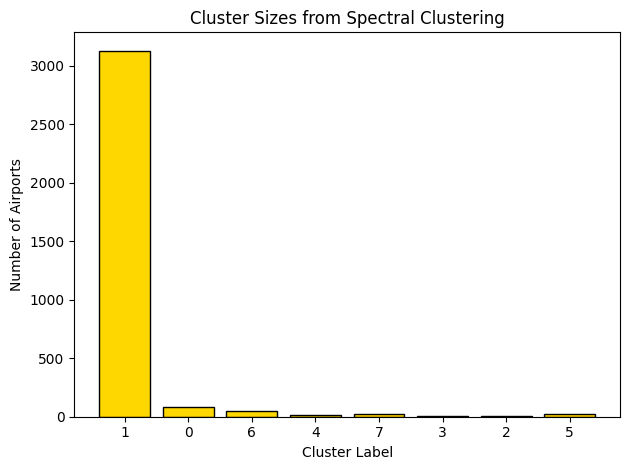

In [ ]:
import matplotlib.pyplot as plt

# clusters is your dict: label -> list of airport IDs
labels = list(clusters.keys())
sizes  = [len(clusters[l]) for l in labels]

plt.figure()
plt.bar(
    [str(l) for l in labels],
    sizes,
    color="gold",
    edgecolor="black"
)
plt.xlabel("Cluster Label")
plt.ylabel("Number of Airports")
plt.title("Cluster Sizes from Spectral Clustering")
plt.tight_layout()
plt.show()


# Insight 7

**Country-Level Connectivity Backbone**

Using Minimum Spanning tree, construct an efficient, low-cost global air connectivity backbone that connects every country with the least total cost, ensuring no redundancy while maintaining full reachability.

In [ ]:
# airports has columns AirportID, Country
airport_country = airports.set_index("AirportID")["Country"].to_dict()


In [ ]:
from collections import defaultdict

# (c1, c2) → list of (distance, airline) tuples
country_edges = defaultdict(list)
for _, r in routes.iterrows():
    c1 = airport_country.get(r["SourceAirportID"])
    c2 = airport_country.get(r["DestAirportID"])
    if c1 and c2 and c1 != c2:
        country_edges[tuple(sorted((c1, c2)))].append(
            (r["DistanceKM"], r["AirlineID"])
        )


In [ ]:
import numpy as np

edges = []
for (c1,c2), vals in country_edges.items():
    dists, airlines = zip(*vals)
    avg_dist = np.mean(dists)
    carrier_count = len(set(airlines))
    weight = avg_dist / carrier_count
    edges.append((c1, c2, weight))


In [ ]:
import networkx as nx

CG = nx.Graph()
CG.add_weighted_edges_from(edges)
T = nx.minimum_spanning_tree(CG, weight="weight")


In [ ]:
print(f"MST has {T.number_of_nodes()} countries and {T.number_of_edges()} edges.")
# Show the “backbone” links
for u,v,w in sorted(T.edges(data="weight"), key=lambda x: x[2])[:10]:
    print(f"{u} ↔ {v}: weight={w:.1f}")


MST has 225 countries and 224 edges.
Congo (Kinshasa) ↔ Congo (Brazzaville): weight=5.2
Netherlands Antilles ↔ Anguilla: weight=9.5
Guernsey ↔ Jersey: weight=9.7
Bahrain ↔ Qatar: weight=12.3
Martinique ↔ Saint Lucia: weight=12.7
Cameroon ↔ Equatorial Guinea: weight=23.1
Antigua and Barbuda ↔ Saint Kitts and Nevis: weight=24.1
Puerto Rico ↔ Virgin Islands: weight=24.1
Burundi ↔ Rwanda: weight=25.2
British Virgin Islands ↔ Virgin Islands: weight=25.5


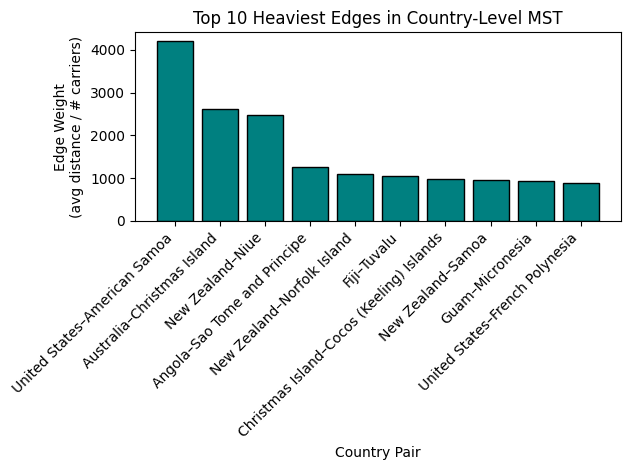

In [ ]:
import matplotlib.pyplot as plt

# T is your MST NetworkX graph with country nodes
# Extract top-10 heaviest edges
edges = sorted(
    T.edges(data="weight"),
    key=lambda x: x[2],
    reverse=True
)[:10]
pairs   = [f"{u}–{v}" for u,v,_ in edges]
weights = [w for _,_,w in edges]

plt.figure()
plt.bar(
    pairs,
    weights,
    color="teal",
    edgecolor="black"
)
plt.xlabel("Country Pair")
plt.ylabel("Edge Weight\n(avg distance / # carriers)")
plt.title("Top 10 Heaviest Edges in Country-Level MST")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
